# Unsupervised Learning: K-Means/Gaussian Mixture Models

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans as SKLearnKMeans
from sklearn.mixture import GaussianMixture as SKLearnGMM
import seaborn as sns

np.random.seed(42)

# K-MEANS IMPLEMENTATION

In [6]:
class KMeans:
    """
    K-Means clustering algorithm implementation.
    
    Parameters:
    -----------
    n_clusters : int
        Number of clusters to form
    max_iter : int
        Maximum number of iterations
    """
    
    def __init__(self, n_clusters=3, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.labels_ = None
        
    def fit(self, X):
        """
        Fit K-Means clustering on dataset X.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Training data
        """
        n_samples, n_features = X.shape
        
        # Initialize centroids randomly from data points
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]
        
        for iteration in range(self.max_iter):
            # Assign clusters
            old_centroids = self.centroids.copy()
            self.labels_ = self._assign_clusters(X)
            
            # Update centroids
            self._update_centroids(X)
            
            # Check for convergence
            if np.allclose(old_centroids, self.centroids):
                print(f"K-Means converged at iteration {iteration}")
                break
                
        return self
    
    def _assign_clusters(self, X):
        """Assign each point to nearest centroid."""
        distances = np.sqrt(((X[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X):
        """Update centroids as mean of assigned points."""
        for k in range(self.n_clusters):
            cluster_points = X[self.labels_ == k]
            if len(cluster_points) > 0:
                self.centroids[k] = cluster_points.mean(axis=0)
    
    def predict(self, X):
        """
        Predict cluster labels for data X.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Data to predict
            
        Returns:
        --------
        labels : numpy array of shape (n_samples,)
            Cluster labels
        """
        return self._assign_clusters(X)

# Gaussian Mixture Model

In [7]:
class GaussianMixtureModel:
    """
    Gaussian Mixture Model clustering using Expectation-Maximization.
    
    Parameters:
    -----------
    n_clusters : int
        Number of Gaussian components
    max_iter : int
        Maximum number of EM iterations
    """
    
    def __init__(self, n_clusters=3, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.means = None
        self.covariances = None
        self.weights = None
        self.labels_ = None
        
    def fit(self, X):
        """
        Fit GMM using EM algorithm.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Training data
        """
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self._initialize_parameters(X)
        
        log_likelihood_old = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step: compute responsibilities
            responsibilities = self._e_step(X)
            
            # M-step: update parameters
            self._m_step(X, responsibilities)
            
            # Compute log likelihood for convergence check
            log_likelihood = self._compute_log_likelihood(X)
            
            if abs(log_likelihood - log_likelihood_old) < 1e-6:
                print(f"GMM converged at iteration {iteration}")
                break
                
            log_likelihood_old = log_likelihood
        
        # Final cluster assignments
        responsibilities = self._e_step(X)
        self.labels_ = np.argmax(responsibilities, axis=1)
        
        return self
    
    def _initialize_parameters(self, X):
        """Initialize GMM parameters using K-Means."""
        n_samples, n_features = X.shape
        
        # Use K-Means for initialization
        kmeans = KMeans(n_clusters=self.n_clusters, max_iter=10)
        kmeans.fit(X)
        
        self.means = kmeans.centroids
        self.weights = np.ones(self.n_clusters) / self.n_clusters
        self.covariances = np.array([np.cov(X.T) for _ in range(self.n_clusters)])
        
    def _e_step(self, X):
        """
        Expectation step: compute responsibilities.
        
        Returns:
        --------
        responsibilities : numpy array of shape (n_samples, n_clusters)
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_clusters))
        
        for k in range(self.n_clusters):
            responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        
        # Normalize
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities
    
    def _m_step(self, X, responsibilities):
        """Maximization step: update parameters."""
        n_samples, n_features = X.shape
        
        # Update weights
        N_k = responsibilities.sum(axis=0)
        self.weights = N_k / n_samples
        
        # Update means
        self.means = (responsibilities.T @ X) / N_k[:, np.newaxis]
        
        # Update covariances
        for k in range(self.n_clusters):
            diff = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k:k+1] * diff).T @ diff / N_k[k]
            # Add small value to diagonal for numerical stability
            self.covariances[k] += np.eye(n_features) * 1e-6
    
    def _compute_log_likelihood(self, X):
        """Compute log likelihood of data."""
        n_samples = X.shape[0]
        log_likelihood = 0
        
        for k in range(self.n_clusters):
            log_likelihood += np.sum(
                np.log(self.weights[k] * multivariate_normal.pdf(
                    X, mean=self.means[k], cov=self.covariances[k]
                ) + 1e-10)
            )
        
        return log_likelihood
    
    def predict(self, X):
        """
        Predict cluster labels for data X.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Data to predict
            
        Returns:
        --------
        labels : numpy array of shape (n_samples,)
            Cluster labels
        """
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)

# Load Data


Dataset Shape: (1000, 2)

First few rows:
       weight      length
0    7.643140   84.411360
1  338.079325  259.918982
2  347.303709  225.203959
3    6.758873   87.143065
4   25.330695  145.428500

Dataset Statistics:
            weight       length
count  1000.000000  1000.000000
mean    126.230138   181.358868
std     143.342021    82.314282
min       2.429054    74.129540
25%       7.665666   116.621083
50%      24.377660   146.636622
75%     251.175233   268.985527
max     387.517645   333.174711


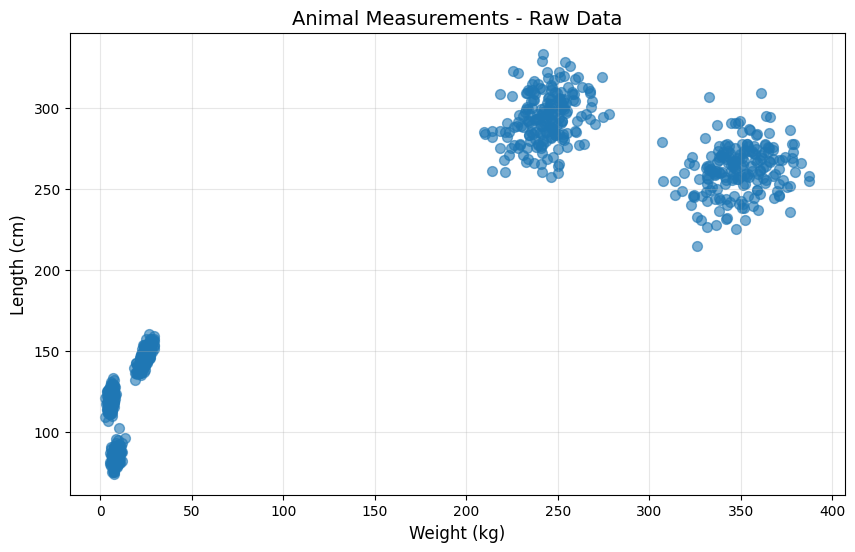

In [8]:
# Load the dataset
df = pd.read_csv("hw4_dataset.csv")

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Statistics:")
print(df.describe())

# Convert to numpy array
X = df.values

# Visualize the raw data
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6, s=50)
plt.xlabel('Weight (kg)', fontsize=12)
plt.ylabel('Length (cm)', fontsize=12)
plt.title('Animal Measurements - Raw Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Find Optimal Number of Clusters

K-Means converged at iteration 1
K-Means converged at iteration 14
K-Means converged at iteration 7
K-Means converged at iteration 10
K-Means converged at iteration 10
K-Means converged at iteration 7


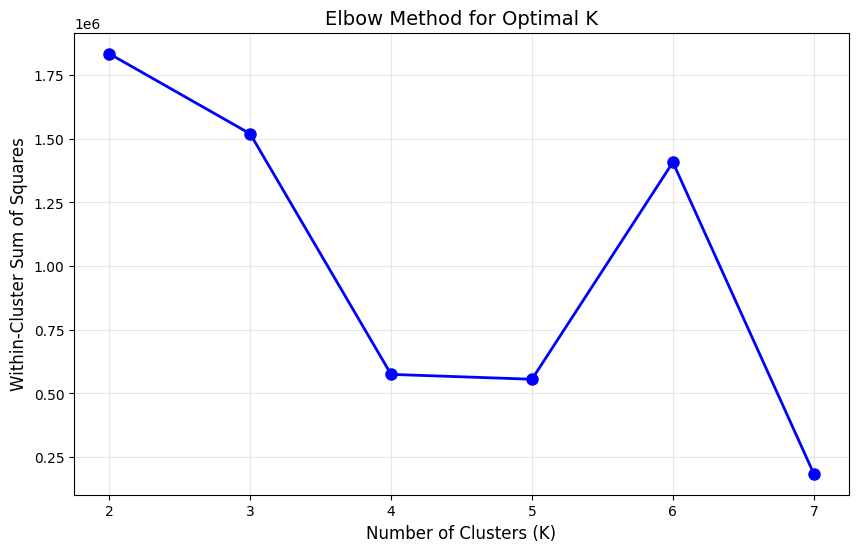

In [9]:
def compute_inertia(X, labels, centroids):
    """Compute within-cluster sum of squares."""
    inertia = 0
    for k in range(len(centroids)):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[k]) ** 2)
    return inertia

# Elbow method
K_range = range(2, 8)
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, max_iter=100)
    kmeans.fit(X)
    inertia = compute_inertia(X, kmeans.labels_, kmeans.centroids)
    inertias.append(inertia)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Optimal K Clustering

In [11]:
optimal_k = 3
print(f"CLUSTERING WITH K = {optimal_k}")

# My K-Means implementation
print("Running custom K-Means...")
my_kmeans = KMeans(n_clusters=optimal_k, max_iter=100)
my_kmeans.fit(X)

# My GMM implementation
print("\nRunning custom GMM...")
my_gmm = GaussianMixtureModel(n_clusters=optimal_k, max_iter=100)
my_gmm.fit(X)

# Scikit-learn implementations for comparison
print("\nRunning scikit-learn K-Means...")
sklearn_kmeans = SKLearnKMeans(n_clusters=optimal_k, random_state=42, n_init=10)
sklearn_kmeans.fit(X)

print("\nRunning scikit-learn GMM...")
sklearn_gmm = SKLearnGMM(n_components=optimal_k, random_state=42)
sklearn_gmm.fit(X)


CLUSTERING WITH K = 3
Running custom K-Means...
K-Means converged at iteration 4

Running custom GMM...
K-Means converged at iteration 2
GMM converged at iteration 5

Running scikit-learn K-Means...

Running scikit-learn GMM...


,n_components,3
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


# Results

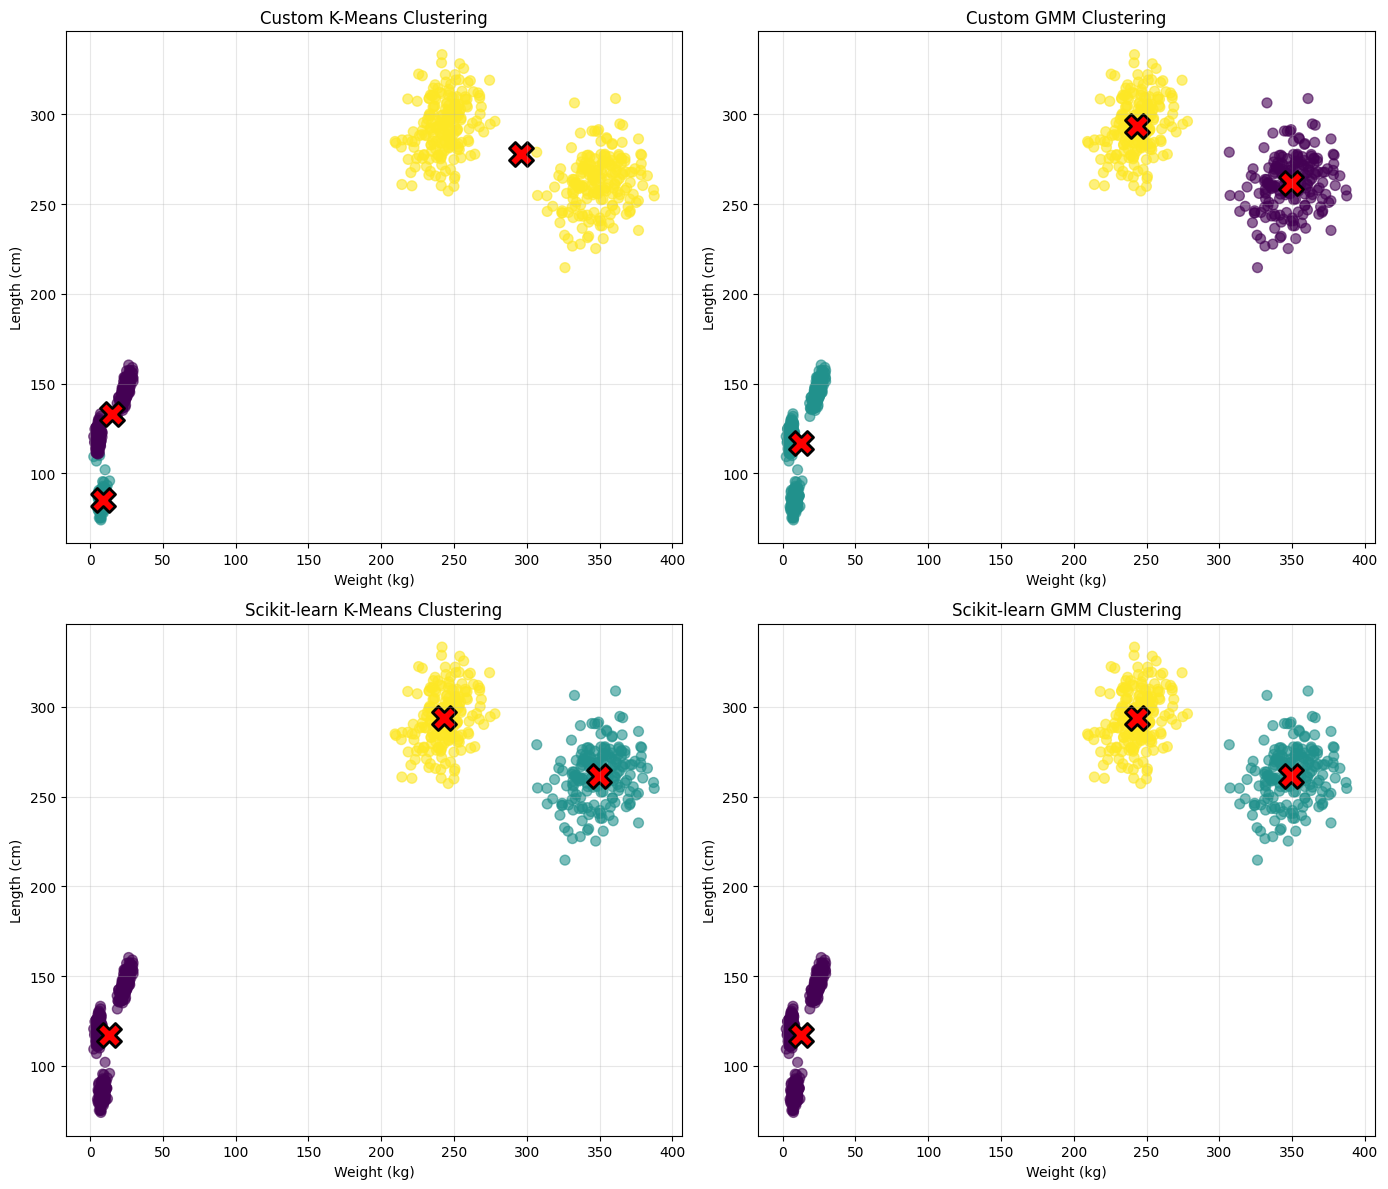

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Custom K-Means
axes[0, 0].scatter(X[:, 0], X[:, 1], c=my_kmeans.labels_, cmap='viridis', 
                   alpha=0.6, s=50)
axes[0, 0].scatter(my_kmeans.centroids[:, 0], my_kmeans.centroids[:, 1], 
                   c='red', marker='X', s=300, edgecolors='black', linewidths=2)
axes[0, 0].set_xlabel('Weight (kg)')
axes[0, 0].set_ylabel('Length (cm)')
axes[0, 0].set_title('Custom K-Means Clustering')
axes[0, 0].grid(True, alpha=0.3)

# Custom GMM
axes[0, 1].scatter(X[:, 0], X[:, 1], c=my_gmm.labels_, cmap='viridis', 
                   alpha=0.6, s=50)
axes[0, 1].scatter(my_gmm.means[:, 0], my_gmm.means[:, 1], 
                   c='red', marker='X', s=300, edgecolors='black', linewidths=2)
axes[0, 1].set_xlabel('Weight (kg)')
axes[0, 1].set_ylabel('Length (cm)')
axes[0, 1].set_title('Custom GMM Clustering')
axes[0, 1].grid(True, alpha=0.3)

# Scikit-learn K-Means
axes[1, 0].scatter(X[:, 0], X[:, 1], c=sklearn_kmeans.labels_, cmap='viridis', 
                   alpha=0.6, s=50)
axes[1, 0].scatter(sklearn_kmeans.cluster_centers_[:, 0], 
                   sklearn_kmeans.cluster_centers_[:, 1], 
                   c='red', marker='X', s=300, edgecolors='black', linewidths=2)
axes[1, 0].set_xlabel('Weight (kg)')
axes[1, 0].set_ylabel('Length (cm)')
axes[1, 0].set_title('Scikit-learn K-Means Clustering')
axes[1, 0].grid(True, alpha=0.3)

# Scikit-learn GMM
axes[1, 1].scatter(X[:, 0], X[:, 1], c=sklearn_gmm.predict(X), cmap='viridis', 
                   alpha=0.6, s=50)
axes[1, 1].scatter(sklearn_gmm.means_[:, 0], sklearn_gmm.means_[:, 1], 
                   c='red', marker='X', s=300, edgecolors='black', linewidths=2)
axes[1, 1].set_xlabel('Weight (kg)')
axes[1, 1].set_ylabel('Length (cm)')
axes[1, 1].set_title('Scikit-learn GMM Clustering')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison

In [13]:
print("CLUSTER ANALYSIS")

# Analyze each cluster
for k in range(optimal_k):
    cluster_data = X[my_kmeans.labels_ == k]
    print(f"Cluster {k}:")
    print(f"  Size: {len(cluster_data)} animals")
    print(f"  Weight: mean={cluster_data[:, 0].mean():.2f} kg, "
          f"std={cluster_data[:, 0].std():.2f} kg")
    print(f"  Length: mean={cluster_data[:, 1].mean():.2f} cm, "
          f"std={cluster_data[:, 1].std():.2f} cm")
    print()

print(f"{'='*60}")
print("POSSIBLE ANIMAL SPECIES")
print(f"{'='*60}\n")

print("Based on the weight and length measurements, the clusters likely represent:")
print("- Small animals (e.g., cats, rabbits)")
print("- Medium animals (e.g., dogs, sheep)")
print("- Large animals (e.g., horses, cattle)")
print("\nThe exact species would depend on the specific cluster characteristics.")


CLUSTER ANALYSIS
Cluster 0:
  Size: 397 animals
  Weight: mean=15.08 kg, std=9.50 kg
  Length: mean=133.39 cm, std=14.14 cm

Cluster 1:
  Size: 203 animals
  Weight: mean=8.50 kg, std=1.44 kg
  Length: mean=85.46 cm, std=5.05 cm

Cluster 2:
  Size: 400 animals
  Weight: mean=296.30 kg, std=54.83 kg
  Length: mean=277.64 cm, std=22.14 cm

POSSIBLE ANIMAL SPECIES

Based on the weight and length measurements, the clusters likely represent:
- Small animals (e.g., cats, rabbits)
- Medium animals (e.g., dogs, sheep)
- Large animals (e.g., horses, cattle)

The exact species would depend on the specific cluster characteristics.
